In [2]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import sys
import sklearn.pipeline
import sklearn.preprocessing

if "../" not in sys.path:
  sys.path.append("../") 

from lib import plotting
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import RBFSampler

matplotlib.style.use('ggplot')

In [3]:
env = gym.envs.make("MountainCar-v0")

[2016-12-30 18:52:11,541] Making new env: MountainCar-v0


In [4]:
# Feature Preprocessing: Normalize to zero mean and unit variance
# We use a few samples from the observation space to do this
observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

# Used to converte a state to a featurizes represenation.
# We use RBF kernels with different variances to cover different parts of the space
featurizer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=100))
        ])
featurizer.fit(scaler.transform(observation_examples))

FeatureUnion(n_jobs=1,
       transformer_list=[('rbf1', RBFSampler(gamma=5.0, n_components=100, random_state=None)), ('rbf2', RBFSampler(gamma=2.0, n_components=100, random_state=None)), ('rbf3', RBFSampler(gamma=1.0, n_components=100, random_state=None)), ('rbf4', RBFSampler(gamma=0.5, n_components=100, random_state=None))],
       transformer_weights=None)

In [10]:
class Estimator():
    """
    Value Function approximator. 
    """
    
    def __init__(self):
        # We create a separate model for each action in the environment's
        # action space. Alternatively we could somehow encode the action
        # into the features, but this way it's easier to code up.
        self.models = []
        for _ in range(env.action_space.n):
            model = SGDRegressor(learning_rate="constant")
            # We need to call partial_fit once to initialize the model
            # or we get a NotFittedError when trying to make a prediction
            # This is quite hacky.
            model.partial_fit([self.featurize_state(env.reset())], [0])
            self.models.append(model)
    
    def featurize_state(self, state):
        """
        Returns the featurized representation for a state.
        """
        scaled = scaler.transform([state])
        featurized = featurizer.transform(scaled)
        return featurized[0]
    
    def predict(self, s, a=None):
        """
        Makes value function predictions.
        
        Args:
            s: state to make a prediction for
            a: (Optional) action to make a prediction for
            
        Returns
            If an action a is given this returns a single number as the prediction.
            If no action is given this returns a vector or predictions for all actions
            in the environment where pred[i] is the prediction for action i.
            
        """
        features = self.featurize_state(s)
        if a == None:
            return np.array([m.predict([features])[0] for m in self.models])
        else:
            return self.models[a].predict([features])[0]
    
    def update(self, s, a, y):
        """
        Updates the estimator parameters for a given state and action towards
        the target y.
        """
        features = self.featurize_state(s)
        self.models[a].partial_fit([features], [y])

In [11]:
def make_epsilon_greedy_policy(estimator, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function approximator and epsilon.
    
    Args:
        estimator: An estimator that returns q values for a given state
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        q_values = estimator.predict(observation)
        best_action = np.argmax(q_values)
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [15]:
def q_learning(env, estimator, num_episodes, discount_factor=1.0, epsilon=0.1, epsilon_decay=1.0):
    """
    Q-Learning algorithm for fff-policy TD control using Function Approximation.
    Finds the optimal greedy policy while following an epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        estimator: Action-Value function estimator
        num_episodes: Number of episodes to run for.
        discount_factor: Lambda time discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
        epsilon_decay: Each episode, epsilon is decayed by this factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    for i_episode in range(num_episodes):
        
        # The policy we're following
        policy = make_epsilon_greedy_policy(
            estimator, epsilon * epsilon_decay**i_episode, env.action_space.n)
        
        # Print out which episode we're on, useful for debugging.
        # Also print reward for last episode
        last_reward = stats.episode_rewards[i_episode - 1]
        print("\rEpisode {}/{} ({})".format(i_episode + 1, num_episodes, last_reward))
        sys.stdout.flush()
        
        # TODO: Implement this!
        state = env.reset()
        for t in itertools.count():
            action = np.random.choice(np.arange(env.action_space.n), p=policy(state))
            next_state, reward, done, _ = env.step(action)
            next_action = np.argmax(policy(next_state))
            estimator.update(a=action, s=state, 
                             y=reward + discount_factor*estimator.predict(s=next_state, a=next_action))
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t

            if done:
                break
            state = next_state
            
    return stats

In [16]:
estimator = Estimator()

In [19]:
# Note: For the Mountain Car we don't actually need an epsilon > 0.0
# because our initial estimate for all states is too "optimistic" which leads
# to the exploration of all states.
stats = q_learning(env, estimator, 1000, epsilon=0.0)

Episode 1/1000 (0.0)
Episode 2/1000 (-147.0)
Episode 3/1000 (-140.0)
Episode 4/1000 (-171.0)
Episode 5/1000 (-151.0)
Episode 6/1000 (-151.0)
Episode 7/1000 (-162.0)
Episode 8/1000 (-111.0)
Episode 9/1000 (-112.0)
Episode 10/1000 (-169.0)
Episode 11/1000 (-146.0)
Episode 12/1000 (-112.0)
Episode 13/1000 (-116.0)
Episode 14/1000 (-148.0)
Episode 15/1000 (-109.0)
Episode 16/1000 (-111.0)
Episode 17/1000 (-120.0)
Episode 18/1000 (-171.0)
Episode 19/1000 (-147.0)
Episode 20/1000 (-111.0)
Episode 21/1000 (-115.0)
Episode 22/1000 (-174.0)
Episode 23/1000 (-111.0)
Episode 24/1000 (-155.0)
Episode 25/1000 (-163.0)
Episode 26/1000 (-158.0)
Episode 27/1000 (-110.0)
Episode 28/1000 (-154.0)
Episode 29/1000 (-110.0)
Episode 30/1000 (-111.0)
Episode 31/1000 (-126.0)
Episode 32/1000 (-146.0)
Episode 33/1000 (-175.0)
Episode 34/1000 (-190.0)
Episode 35/1000 (-108.0)
Episode 36/1000 (-109.0)
Episode 37/1000 (-111.0)
Episode 38/1000 (-113.0)
Episode 39/1000 (-111.0)
Episode 40/1000 (-113.0)
Episode 41/1

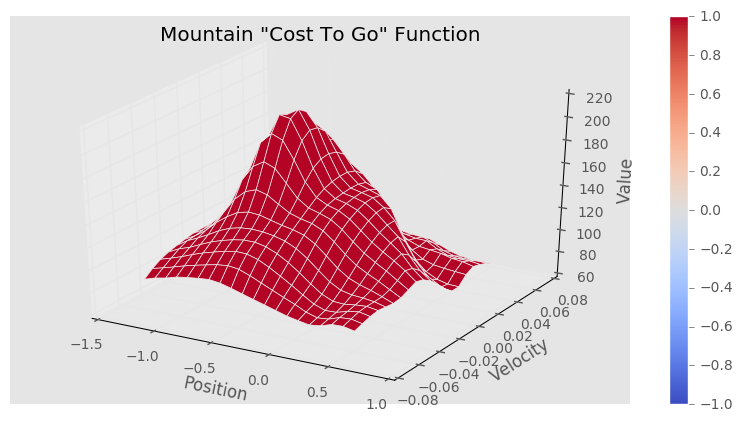

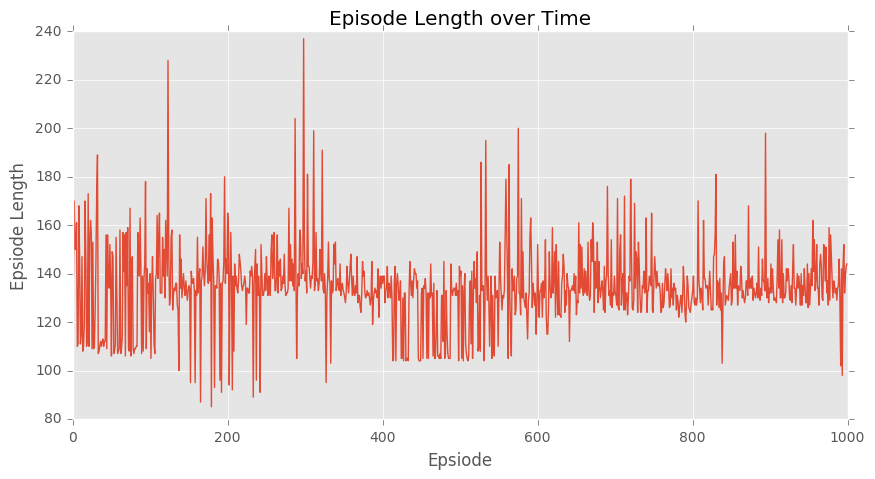

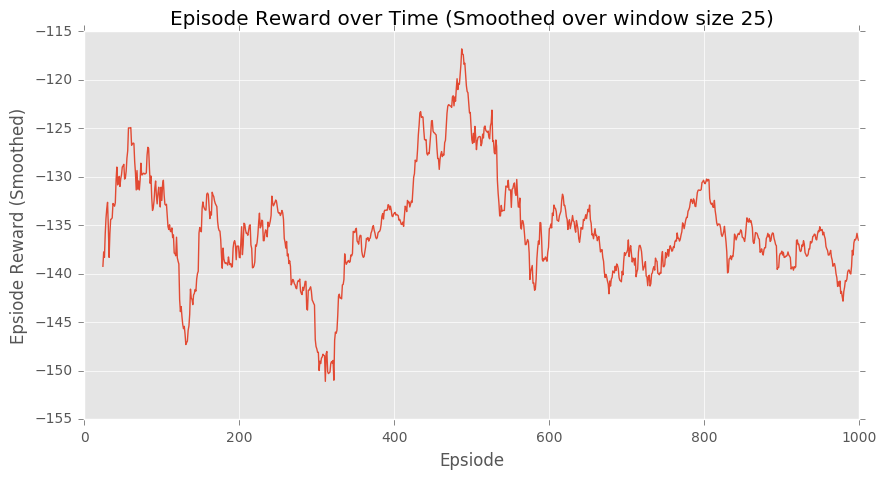

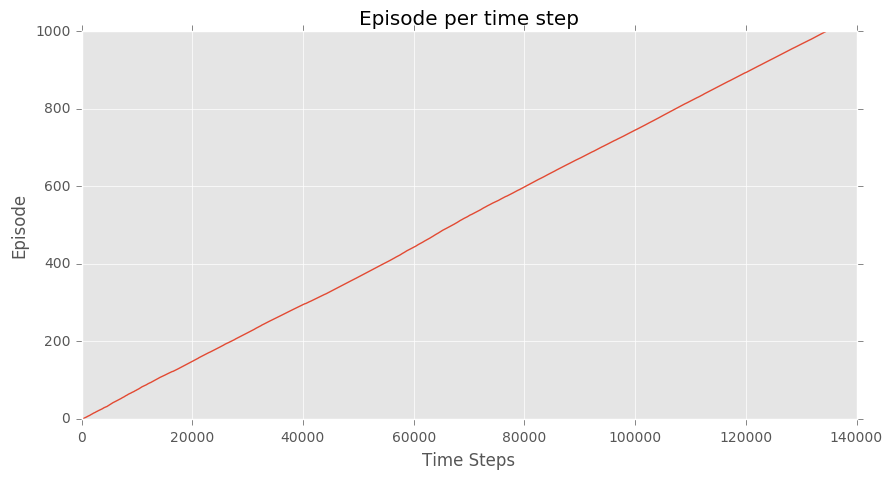

(<matplotlib.figure.Figure at 0x116094310>,
 <matplotlib.figure.Figure at 0x116e69e90>)

In [20]:
plotting.plot_cost_to_go_mountain_car(env, estimator)
plotting.plot_episode_stats(stats, smoothing_window=25)